In [1]:
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install bs4
!pip install nltk
!pip install matplotlib

In [2]:
import pandas as pd
import os
import json
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from matplotlib import pyplot

In [3]:
import nltk
nltk.download('all', quiet = True)
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

In [4]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

   "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

   "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

   "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

   "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

   "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

   "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

   "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

   "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

   "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

   "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

   "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

   "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

   "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

   "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

   "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

   "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

   "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

   "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

   "you're": "you are", "you've": "you have"
}

stop_words = set(stopwords.words('english')) 

def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [5]:
# Read all the data
labels = []
raw_inputs = []
df = pd.read_csv('./raw_data.csv')
max_frames = 0
max_words = 0
max_sequence_length = 0

for index, row in df.iterrows():
    path = os.path.join('./processed_video', 'audio_' + row['video_id'] + '_txt')
    
    if os.path.isfile(path):
        with open(path, 'r') as f:
            try:
                raw_inputs_video = []
                sequence_length = 0
                file_data = json.load(f)
                num_frames = len(file_data)
                
                if num_frames > max_frames:
                    max_frames = num_frames

                for i in range(num_frames):
                    line_data = json.loads(file_data[i])

                    if 'DisplayText' in line_data.keys():
                        sentence = line_data['DisplayText']
                        cleaned_sentence = text_cleaner(sentence)
                        num_words = len(cleaned_sentence.split())
                        sequence_length = sequence_length + num_words

                        if num_words > max_words:
                            max_words = num_words
                        raw_inputs_video.append(cleaned_sentence)

                    del line_data
                
                raw_inputs.append(raw_inputs_video)
                labels.append((row['video_likeCount'] - row['video_dislikeCount'])/row['video_viewCount'])
                
                if sequence_length > max_sequence_length:
                    max_sequence_length = sequence_length

                del raw_inputs_video, file_data, sequence_length
            except ValueError:
                print(path + ' failed processing')

raw_inputs = np.array(raw_inputs)
labels = np.array(labels)
print()
print('Shape of raw_inputs: ', raw_inputs.shape)
print('Shape of labels: ', labels.shape)
print('Max Words: ', max_words)
print('Max Frames: ', max_frames)
print('Max Sequence Lenghth: ', max_sequence_length)
np.save('./text.npy', raw_inputs)

./processed_video/audio_xCgk9nvuCxk_txt failed processing
./processed_video/audio_Q_ouhkdo-ko_txt failed processing

Shape of raw_inputs:  (3389,)
Shape of labels:  (3389,)
Max Words:  84
Max Frames:  186
Max Sequence Lenghth:  1500


In [6]:
label_series = pd.Series(labels)
print(label_series.value_counts(bins=20).sort_index())

(-0.021500000000000002, -0.0122]       1
(-0.0122, -0.00398]                    7
(-0.00398, 0.00421]                  225
(0.00421, 0.0124]                   1094
(0.0124, 0.0206]                    1021
(0.0206, 0.0288]                     613
(0.0288, 0.037]                      264
(0.037, 0.0452]                      103
(0.0452, 0.0533]                      31
(0.0533, 0.0615]                      17
(0.0615, 0.0697]                       5
(0.0697, 0.0779]                       2
(0.0779, 0.0861]                       1
(0.0861, 0.0943]                       1
(0.0943, 0.102]                        0
(0.102, 0.111]                         1
(0.111, 0.119]                         1
(0.119, 0.127]                         0
(0.127, 0.135]                         1
(0.135, 0.143]                         1
dtype: int64


In [7]:
# Prepare data for cnn lstm by concatenating frames, normalizing labels and defining constants
text_inputs = [''.join(row) for row in raw_inputs]
labels = np.clip(labels, 0.000938, 0.0452)
scaler = MinMaxScaler()
scaled_labels = scaler.fit_transform(labels.reshape(-1,1)).flatten()
scaled_labels_lower = scaled_labels < 0.3
scaled_labels_lower = scaled_labels_lower * 1
scaled_labels_mid = (scaled_labels >= 0.3) & (scaled_labels <=6)
scaled_labels_mid = scaled_labels_mid * 1
scaled_labels_upper = scaled_labels > 0.6
scaled_labels_upper = scaled_labels_upper * 1

MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = max_sequence_length
VALIDATION_SPLIT = 0.3
GLOVE_DIR = './glove.twitter.27B'
EMBEDDING_DIM = 200

In [8]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text_inputs)
sequences = tokenizer.texts_to_sequences(text_inputs)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', scaled_labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = scaled_labels[indices]
labels_lower = scaled_labels_lower[indices]
labels_mid = scaled_labels_mid[indices]
labels_upper = scaled_labels_upper[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
y_train_lower = labels_lower[:-nb_validation_samples]
y_train_mid = labels_mid[:-nb_validation_samples]
y_train_upper = labels_upper[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
y_val_lower = labels_lower[-nb_validation_samples:]
y_val_mid = labels_mid[-nb_validation_samples:]
y_val_upper = labels_upper[-nb_validation_samples:]
print('Shape of training tensor:', x_train.shape)
print('Shape of training labels:', y_train.shape)
print('Shape of testing tensor:', x_val.shape)
print('Shape of testing labels:', y_val.shape)

Found 121402 unique tokens.
Shape of data tensor: (3389, 1500)
Shape of label tensor: (3389,)
Shape of training tensor: (2373, 1500)
Shape of training labels: (2373,)
Shape of testing tensor: (1016, 1500)
Shape of testing labels: (1016,)


In [9]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [10]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [11]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [12]:
# lower one versus all
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model_1 = Model(sequence_input, preds)
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.Accuracy()])

print(model_1.summary())

# happy learning!
history = model_1.fit(x_train, y_train_lower, validation_split=0.1,
          epochs=100, batch_size=128)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1500)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1500, 200)         24280600  
_________________________________________________________________
conv1d (Conv1D)              (None, 1496, 128)         128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 299, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 295, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 59, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 128)           82048 

2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6646 - accuracy: 4.6838e-04 - val_loss: 0.7753 - val_accuracy: 0.0000e+00
Epoch 42/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 4.6838e-04 - val_loss: 0.7813 - val_accuracy: 0.0000e+00
Epoch 43/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 4.6838e-04 - val_loss: 0.7740 - val_accuracy: 0.0000e+00
Epoch 44/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 4.6838e-04 - val_loss: 0.7773 - val_accuracy: 0.0000e+00
Epoch 45/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 4.6838e-04 - val_loss: 0.7775 - val_accuracy: 0.0000e+00
Epoch 46/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 4.6838e-04 - val_loss: 0.7804 - val_accuracy: 0.0000e+00
Epoch 47/100
2135/2135 [==============================] - 17s 8ms/sampl

2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 9.3677e-04 - val_loss: 0.7953 - val_accuracy: 0.0000e+00
Epoch 94/100
2135/2135 [==============================] - 18s 8ms/sample - loss: 0.6646 - accuracy: 9.3677e-04 - val_loss: 0.7912 - val_accuracy: 0.0000e+00
Epoch 95/100
2135/2135 [==============================] - 18s 9ms/sample - loss: 0.6644 - accuracy: 9.3677e-04 - val_loss: 0.8060 - val_accuracy: 0.0000e+00
Epoch 96/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6646 - accuracy: 9.3677e-04 - val_loss: 0.7973 - val_accuracy: 0.0000e+00
Epoch 97/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 9.3677e-04 - val_loss: 0.7820 - val_accuracy: 0.0000e+00
Epoch 98/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0014 - val_loss: 0.7868 - val_accuracy: 0.0000e+00
Epoch 99/100
2135/2135 [==============================] - 17s 8ms/sample - 

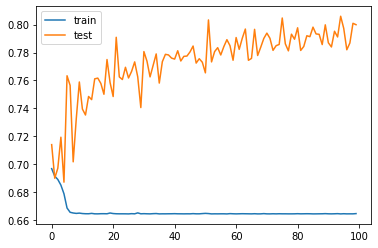

In [13]:
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [14]:
predictions = model_1.predict(x_val)
predictions = predictions > 0.5
y_pred = predictions * 1
y_true = y_val_lower
print(classification_report(y_true, y_pred, labels = [0,1], zero_division=0))
print()
print("The final F1 micro score for the model is: ", f1_score(y_true, y_pred, average = 'micro', labels=[0,1,2,3,4]))
print()
print("Detailed Confusion Matrix")
print()
print(confusion_matrix(y_true, y_pred, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.55      0.99      0.70       557
           1       0.36      0.01      0.02       459

    accuracy                           0.55      1016
   macro avg       0.46      0.50      0.36      1016
weighted avg       0.46      0.55      0.39      1016


The final F1 micro score for the model is:  0.5452755905511811

Detailed Confusion Matrix

[[550   7]
 [455   4]]


In [15]:
model_2 = Model(sequence_input, preds)
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.Accuracy()])

print(model_2.summary())

# happy learning!
history = model_2.fit(x_train, y_train_lower, validation_split=0.1,
          epochs=100, batch_size=128)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1500)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1500, 200)         24280600  
_________________________________________________________________
conv1d (Conv1D)              (None, 1496, 128)         128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 299, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 295, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 59, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 128)           8204

2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0150 - val_loss: 0.8456 - val_accuracy: 0.0000e+00
Epoch 43/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0141 - val_loss: 0.8436 - val_accuracy: 0.0000e+00
Epoch 44/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0169 - val_loss: 0.8452 - val_accuracy: 0.0000e+00
Epoch 45/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0150 - val_loss: 0.8522 - val_accuracy: 0.0000e+00
Epoch 46/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0145 - val_loss: 0.8426 - val_accuracy: 0.0000e+00
Epoch 47/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0159 - val_loss: 0.8531 - val_accuracy: 0.0000e+00
Epoch 48/100
2135/2135 [==============================] - 16s 8ms/sample - loss: 0.6645 - accur

2135/2135 [==============================] - 18s 8ms/sample - loss: 0.6645 - accuracy: 0.0141 - val_loss: 0.8632 - val_accuracy: 0.0000e+00
Epoch 96/100
2135/2135 [==============================] - 18s 8ms/sample - loss: 0.6645 - accuracy: 0.0169 - val_loss: 0.8652 - val_accuracy: 0.0000e+00
Epoch 97/100
2135/2135 [==============================] - 18s 8ms/sample - loss: 0.6645 - accuracy: 0.0164 - val_loss: 0.8678 - val_accuracy: 0.0000e+00
Epoch 98/100
2135/2135 [==============================] - 18s 9ms/sample - loss: 0.6645 - accuracy: 0.0169 - val_loss: 0.8623 - val_accuracy: 0.0000e+00
Epoch 99/100
2135/2135 [==============================] - 18s 8ms/sample - loss: 0.6645 - accuracy: 0.0155 - val_loss: 0.8776 - val_accuracy: 0.0000e+00
Epoch 100/100
2135/2135 [==============================] - 18s 8ms/sample - loss: 0.6645 - accuracy: 0.0155 - val_loss: 0.8621 - val_accuracy: 0.0000e+00


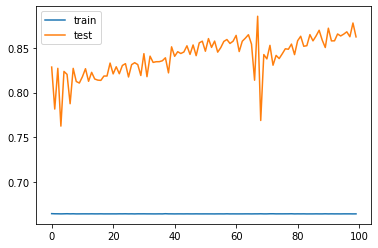

In [16]:
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [17]:
predictions = model_2.predict(x_val)
predictions = predictions > 0.5
y_pred = predictions * 1
y_true = y_val_lower
print(classification_report(y_true, y_pred, labels = [0,1], zero_division=0))
print()
print("The final F1 micro score for the model is: ", f1_score(y_true, y_pred, average = 'micro', labels=[0,1,2,3,4]))
print()
print("Detailed Confusion Matrix")
print()
print(confusion_matrix(y_true, y_pred, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.55      0.99      0.70       557
           1       0.36      0.01      0.02       459

    accuracy                           0.55      1016
   macro avg       0.46      0.50      0.36      1016
weighted avg       0.46      0.55      0.39      1016


The final F1 micro score for the model is:  0.5452755905511811

Detailed Confusion Matrix

[[550   7]
 [455   4]]


In [18]:
model_3 = Model(sequence_input, preds)
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.Accuracy()])

print(model_3.summary())

# happy learning!
history = model_3.fit(x_train, y_train_lower, validation_split=0.1,
          epochs=100, batch_size=128)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1500)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1500, 200)         24280600  
_________________________________________________________________
conv1d (Conv1D)              (None, 1496, 128)         128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 299, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 295, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 59, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 128)           8204

2135/2135 [==============================] - 18s 8ms/sample - loss: 0.6645 - accuracy: 0.0169 - val_loss: 0.8714 - val_accuracy: 0.0000e+00
Epoch 43/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0169 - val_loss: 0.8789 - val_accuracy: 0.0000e+00
Epoch 44/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0155 - val_loss: 0.8836 - val_accuracy: 0.0000e+00
Epoch 45/100
2135/2135 [==============================] - 16s 8ms/sample - loss: 0.6645 - accuracy: 0.0164 - val_loss: 0.8839 - val_accuracy: 0.0000e+00
Epoch 46/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0164 - val_loss: 0.8808 - val_accuracy: 0.0000e+00
Epoch 47/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6644 - accuracy: 0.0169 - val_loss: 0.8711 - val_accuracy: 0.0000e+00
Epoch 48/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accur

2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0169 - val_loss: 0.8811 - val_accuracy: 0.0000e+00
Epoch 96/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0169 - val_loss: 0.8857 - val_accuracy: 0.0000e+00
Epoch 97/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0169 - val_loss: 0.8982 - val_accuracy: 0.0000e+00
Epoch 98/100
2135/2135 [==============================] - 16s 8ms/sample - loss: 0.6645 - accuracy: 0.0169 - val_loss: 0.8892 - val_accuracy: 0.0000e+00
Epoch 99/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6645 - accuracy: 0.0164 - val_loss: 0.9009 - val_accuracy: 0.0000e+00
Epoch 100/100
2135/2135 [==============================] - 17s 8ms/sample - loss: 0.6644 - accuracy: 0.0164 - val_loss: 0.8930 - val_accuracy: 0.0000e+00


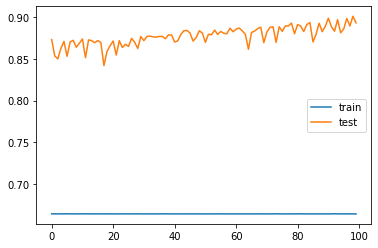

In [19]:
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [20]:
predictions = model_3.predict(x_val)
predictions = predictions > 0.5
y_pred = predictions * 1
y_true = y_val_lower
print(classification_report(y_true, y_pred, labels = [0,1], zero_division=0))
print()
print("The final F1 micro score for the model is: ", f1_score(y_true, y_pred, average = 'micro', labels=[0,1,2,3,4]))
print()
print("Detailed Confusion Matrix")
print()
print(confusion_matrix(y_true, y_pred, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.55      0.99      0.71       557
           1       0.44      0.01      0.02       459

    accuracy                           0.55      1016
   macro avg       0.50      0.50      0.36      1016
weighted avg       0.50      0.55      0.39      1016


The final F1 micro score for the model is:  0.547244094488189

Detailed Confusion Matrix

[[552   5]
 [455   4]]
